# Variational autoencoder via score matching

This is an implementation of a Variational Autoencoder (VAE) variant in which the posterior is estimated by minimizing the Fisher divergence rather than the KL divergence. The algorithm is described in Section 2.1 of [Variational inference via score matching](https://github.com/nataliedoss/Score-matching-variational-inference/blob/master/sm_vi.pdf).

This notebook is adapted from the variational autoencoder notebook of [Jan Hendrik Metzen](https://jmetzen.github.io/2015-11-27/vae.html). Modifications were made by Natalie Doss. Our algorithm performs the same tasks as the VAE (reconstruction and new data generation), but uses a different method for performing posterior inference. For a review of the variational autoencoder, see Section 4 of [Variational Inference: A Review](https://github.com/nataliedoss/Score-matching-variational-inference/blob/master/vi.pdf).

The MNIST dataset, distributed by Yann Lecun's [THE MNIST DATABASE of handwritten digits](http://yann.lecun.com/exdb/mnist/) website, consists of pair "handwritten digit image" and "label". The image is a gray scale image with 28 x 28 pixels. Pixel values range from 0 (black) to 255 (white), scaled in the [0, 1] interval. The label is the actual digit, ranging from 0 to 9, the image represents.

In [1]:
import tensorflow as tf

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)
tf.set_random_seed(0)

### Load MNIST data in a format suited for Tensorflow

The 'input_data' script is available at: https://raw.githubusercontent.com/tensorflow/tensorflow/master/tensorflow/examples/tutorials/mnist/input_data.py

In [2]:
import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
n_samples = mnist.train.num_examples

W0901 15:27:28.408696 140736080167808 deprecation.py:323] From <ipython-input-2-3fb1d7c878c6>:2: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0901 15:27:28.410002 140736080167808 deprecation.py:323] From /Users/nataliedoss/venv/lib/python3.7/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W0901 15:27:28.411458 140736080167808 deprecation.py:323] From /Users/nataliedoss/venv/lib/python3.7/site-packages/tensorflow/contrib/learn/python/learn/datasets/base.py:252: _internal_retry.<locals>.wrap.<locals>.wrapped_fn (from tensorflow.contrib.learn.python.learn.datasets.base) is depr

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz


W0901 15:27:29.489943 140736080167808 deprecation.py:323] From /Users/nataliedoss/venv/lib/python3.7/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.
W0901 15:27:29.493236 140736080167808 deprecation.py:323] From /Users/nataliedoss/venv/lib/python3.7/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:110: dense_to_one_hot (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.one_hot on tensors.


Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz


W0901 15:27:29.816005 140736080167808 deprecation.py:323] From /Users/nataliedoss/venv/lib/python3.7/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Code for Xavier initialization of network weights

Why Xavier initialization:
https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow

Xavier initialization in Tensorflow:
https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow

In [3]:
def xavier_init(fan_in, fan_out, constant = 1): 
    
    low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
    high = constant*np.sqrt(6.0/(fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), 
                             minval = low, maxval = high, 
                             dtype = tf.float32)

### Code for the score matching optimization

In [4]:
class VariationalAutoencoder(object):
    
    def __init__(self, network_architecture, 
                 learning_rate = 0.001, batch_size = 100):
        self.network_architecture = network_architecture
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        # Create a placeholder for input
        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])
        
        # Create recognition and generator networks (a.k.a the encoder and decoder)
        self._create_network()
        
        # Define the loss function and the corresponding optimizer
        self._create_loss_optimizer()
        
        # Initialize Tensorflow variables
        init = tf.global_variables_initializer()

        # Launch session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
    
    
    def _create_network(self):
        
        # Initialize network weights and biases
        network_weights = self._initialize_weights(**self.network_architecture)

        n_z = self.network_architecture["n_z"]
        m = self.network_architecture["m"]
        sigma_xi = self.network_architecture["sigma_xi"]

        self.z = self._recognition_network(network_weights["weights_recog"],
                                    network_weights["biases_recog"])
        
        self.xi = self.z + tf.random_normal((self.batch_size, m), 0, sigma_xi, dtype = tf.float32)

        self.y = self._generator_network(network_weights["weights_gener"],
                                    network_weights["biases_gener"])
            
            
    def _initialize_weights(self, n_hidden_recog_1, n_hidden_gener_1,
                            n_input, n_z, m, sigma_xi):
        all_weights = dict()
        all_weights['weights_recog'] = {
            'W3': tf.Variable(xavier_init(n_input, n_hidden_recog_1)),
            'W4': tf.Variable(xavier_init(n_hidden_recog_1, n_hidden_recog_1)),
            'W5': tf.Variable(xavier_init(n_hidden_recog_1, n_z))}
        all_weights['biases_recog'] = {
            'b3': tf.Variable(tf.zeros([n_hidden_recog_1], dtype = tf.float32)),
            'b4': tf.Variable(tf.zeros([n_hidden_recog_1], dtype = tf.float32)),
            'b5': tf.Variable(tf.zeros([n_z], dtype = tf.float32))}
        all_weights['weights_gener'] = {
            'W1': tf.Variable(xavier_init(m*n_z, n_hidden_gener_1)),
            'W2': tf.Variable(xavier_init(n_hidden_gener_1, n_input))}
        all_weights['biases_gener'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype = tf.float32)),
            'b2': tf.Variable(tf.zeros([n_input], dtype = tf.float32))}
        return all_weights
            
        
    def _recognition_network(self, weights, biases): 

        h = tf.nn.tanh(tf.add(tf.matmul(self.x, weights['W3']), biases['b3'])) 
        h1 = tf.add(tf.matmul(h, weights['W4']), biases['b4'])
        z = tf.nn.tanh(tf.add(tf.matmul(h1, weights['W5']), biases['b5']))
        return z

    
    def _generator_network(self, weights, biases): 

        layer1 = tf.nn.tanh(tf.add(tf.matmul(self.xi, weights['W1']), biases['b1'])) 
        y = tf.nn.sigmoid(tf.add(tf.matmul(layer1, weights['W2']), biases['b2']))
        return y
           
        
    def _create_loss_optimizer(self):   
        
        sigma_xi = self.network_architecture["sigma_xi"]
        
        em_loss = self.x * tf.log(1e-10 + self.y) + (1 - self.x) * tf.log(1e-10 + 1 - self.y)

        reconstr_loss = tf.reduce_sum(self.x * tf.log(1e-10 + self.y) + (1 - self.x) * tf.log(1e-10 + 1 - self.y), 1)
         
        grad_by_xi = tf.gradients(reconstr_loss, self.xi)[0]
        self.cost = tf.square(tf.norm(self.z - self.xi - sigma_xi**2 * (grad_by_xi - self.xi))) + tf.square(tf.norm(reconstr_loss))
        self.optimizer = \
            tf.train.AdamOptimizer(learning_rate = self.learning_rate).minimize(self.cost)
        
        
    def partial_fit(self, X):
        # Train the model based on mini-batch of input data 
        # and return the cost of mini-batch.
        opt, cost = self.sess.run((self.optimizer, self.cost), 
                                  feed_dict={self.x: X})
        return cost
    
    
    def transform(self, X):
        # Transform data by mapping it into the latent space.
        return self.sess.run(self.z_mean, feed_dict = {self.x: X})
    
    
    def generate(self, z_mu = None):
        # Generate data by sampling from the latent space.
        # If z_mu is not None, data for this point in the latent space is
        # generated. Otherwise, z_mu is drawn from prior in the latent space.        
        if z_mu is None:
            z_mu = np.random.normal(size = self.network_architecture["n_z"])
            
        return self.sess.run(self.y, feed_dict = {self.z: z_mu})
    
    
    def reconstruct(self, X):
        # Reconstruct given data using the trained VAE.
        return self.sess.run(self.y, feed_dict = {self.x: X})

### Code for training VAE using mini-batches

In [5]:
def train(network_architecture, learning_rate = 0.001,
          batch_size = 100, training_epochs = 10, display_step = 5):
    vae = VariationalAutoencoder(network_architecture, 
                                 learning_rate = learning_rate, 
                                 batch_size = batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)
        
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, _ = mnist.train.next_batch(batch_size)

            # Fit training using batch data
            cost = vae.partial_fit(batch_xs)
            
            # Compute average loss
            avg_cost += cost / n_samples * batch_size

        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), 
                  "cost=", "{:.9f}".format(avg_cost))
            
    return vae

### Training the algorithm on the MNIST

In [6]:
n_z = 20
m = 1
sigma_xi = 1.0

network_architecture = \
    dict(n_hidden_recog_1 = 200, # 1st layer encoder neurons
         n_hidden_gener_1 = 200, # 1st layer decoder neurons
         n_input = 784, # MNIST data input (28*28 pixels)
         n_z = n_z,
         m = m,
         sigma_xi = sigma_xi) 

vae = train(network_architecture, training_epochs = 30)

Epoch: 0001 cost= 5039410.489545463
Epoch: 0006 cost= 3686581.028181826
Epoch: 0011 cost= 1043500.852045455
Epoch: 0016 cost= 859010.781590909
Epoch: 0021 cost= 781923.300454545
Epoch: 0026 cost= 731688.515681819


### Reconstruction of the input data

On the left are MNIST data samples, and on the right are their reconstructions by the trained algorithm.

In our algorithm, the posterior $q_{\phi}(z | x)$ is estimated using Fisher divergence (score matching loss) rather than the KL divergence. The likelihood is $p_{\theta}(x | z)$; its parameters $\theta$ are estimated via variational EM. 

To reconstruct a data point $x$ (an MNIST data point), we do the following map: $x \rightarrow q_{\hat \phi}(z \vert x) \rightarrow z \rightarrow p_{\hat \theta}(x \vert z) \rightarrow x$. 

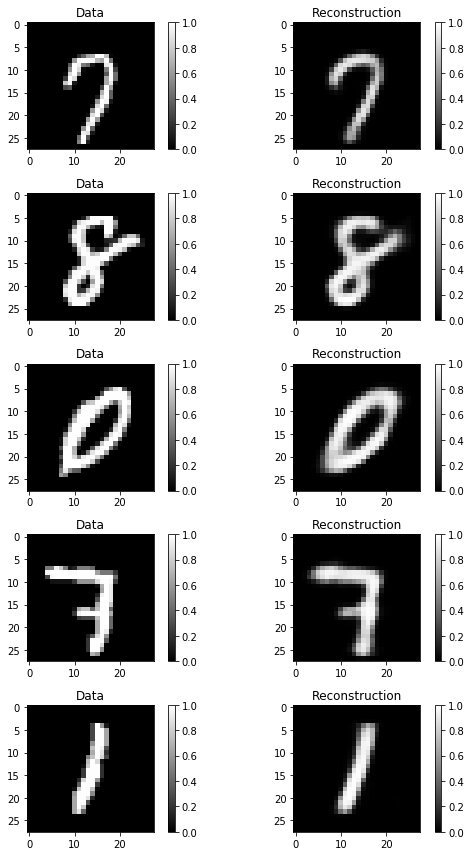

In [7]:
x_sample = mnist.test.next_batch(100)[0]
x_reconstruct = vae.reconstruct(x_sample)

plt.figure(figsize=(8, 12))
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin = 0, vmax = 1, cmap = "gray")
    plt.title("Data")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(28, 28), vmin = 0, vmax = 1, cmap = "gray")
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()

### Generating new data from the trained algorithm

To generate synthetic data, we sample $z \sim N(0, I_d)$. We then feed: $z \rightarrow p_{\hat \theta} (x | z)$ to generate new $x$. 

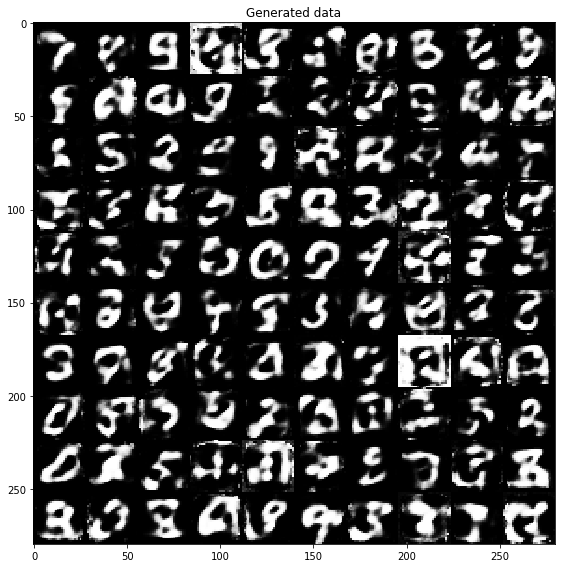

In [8]:
new_z = np.random.normal(size = [100, n_z]) # [batch size, dimensionality of latent space]
new_data = vae.generate(new_z)

n = np.sqrt(vae.batch_size).astype(np.int32)
I_generated = np.empty((28*n, 28*n))
for i in range(n):
    for j in range(n):
        I_generated[i*28:(i+1)*28, j*28:(j+1)*28] = new_data[i*n+j, :].reshape(28, 28)

plt.figure(figsize = (8, 8))
plt.title("Generated data")
plt.imshow(I_generated, cmap = 'gray')
plt.tight_layout()

### Code references

https://jmetzen.github.io/2015-11-27/vae.html

https://github.com/hwalsuklee/tensorflow-mnist-VAE

https://github.com/shaohua0116/VAE-Tensorflow